In [1]:
#!pip install --upgrade keras

import sys
import keras
from keras import backend as K
import os
from PIL import Image
from keras.models import load_model
import matplotlib.patches as patches
from matplotlib import pyplot


print('Keras version:',keras.__version__)

# confirm mtcnn was installed correctly
import mtcnn
# print version
print(mtcnn.__version__)


Using TensorFlow backend.


Keras version: 2.2.4
0.0.9


In [2]:
def load_facenet_model():
    # load the model
    model_path = "/faceml/keras-facenet/model/facenet_keras.h5"
    model = load_model(model_path)
    model.load_weights('/faceml/keras-facenet/weights/facenet_keras_weights.h5')
    # summarize input and output shape
    print(model.inputs)
    print(model.outputs)
    return model

In [3]:
from PIL import Image, ImageOps 
from numpy import asarray
from mtcnn.mtcnn import MTCNN

def load_image(filename):
    try:
        image = Image.open(filename)
        image = resize_image(image,(160,160))
        # convert to RGB, if needed
        image = image.convert('RGB')
        # convert to array
        pixels = asarray(image)
        return pixels
    except:
        return None
    

def extract_face(detector, filename):    
    x1,y1,x2,y2,faces = extract_all_faces(detector, filename)
    if (faces is None or len(faces)==0):
        return (None,)*5
    return x1[0],y1[0],x2[0],y2[0],faces[0]    

# extract a single face from a given photograph
def extract_all_faces(detector, filename, required_size=(160, 160)):
    x1,y1,x2,y2 = list(),list(),list(),list()
    faces=list()
    # load image from file
    # convert to array
    pixels = load_image(filename)
    if (pixels is None):
        return (None,)*5
    # detect faces in the image
    results = detector.detect_faces(pixels)
   # extract the bounding box from the first face
    if (len(results) > 0):
        for i in range(len(results)):
            x=results[i]['box'][0]
            y=results[i]['box'][1]
            width=results[i]['box'][2]
            height= results[i]['box'][3]
            #x1[i], y1[i], width, height = results[i]['box']
            # bug fix
            x,y = abs(x), abs(y)
            # extract the face
            #print(i, x1[i], y1[i],width,height)
            face = pixels[y:y+height, x:x+width]
            (fH, fW) = face.shape[:2]
            if fW < 10 or fH < 10:
                continue
            x1.append(x)
            y1.append(y)
            x2.append(x1[i] + width)
            y2.append(y1[i] + height)
            # resize pixels to the model size
            image = Image.fromarray(face)
            image = image.resize(required_size)
            face_array = asarray(image)
            faces.append(face_array)                              
        return x1, y1, x2, y2, faces
    else:
        return (None,)*5

def resize_image(src_image, size=(128,128)): 
    
    # resize the image so the longest dimension matches our target size
    src_image.thumbnail(size, Image.ANTIALIAS)
    
    # Create a new square background image
    new_image = Image.new("RGB", size)
    
    # Paste the resized image into the center of the square background
    new_image.paste(src_image, (int((size[0] - src_image.size[0]) / 2), int((size[1] - src_image.size[1]) / 2)))
  
    # return the resized image
    return new_image


In [4]:
from os import listdir
from os.path import isdir

def load_faces(detector, directory):
    faces = list()
    # enumerate files
    for filename in listdir(directory):
        # path
        path = directory + filename
        # get face
        x1, y1, x2, y2, face = extract_face(detector, path)
        if face is not None:
            # store
            faces.append(face)
    return faces

def load_dataset(detector,directory):
    X, y = list(), list()
    # enumerate folders, on per class
    for subdir in listdir(directory):
        # path
        path = directory + subdir + '/'
        # skip any files that might be in the dir
        if not isdir(path):
            continue
        # load all faces in the subdirectory
        faces = load_faces(detector,path)
        if (len(faces)>0):
            # create labels
            labels = [subdir for _ in range(len(faces))]
            # summarize progress
            print('>loaded %d examples for class: %s' % (len(faces), subdir))
            # store
            X.extend(faces)
            y.extend(labels)
    return asarray(X), asarray(y)

In [5]:
# load train dataset
from numpy import savez_compressed

training_folder = '/images/whatsapp/training/family/'
validation_folder = '/images/whatsapp/val/'
model_folder='/images/whatsapp/training/'

detector = MTCNN()
trainX, trainy = load_dataset(detector,training_folder)
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset(detector,validation_folder)
print(testX.shape, testy.shape)

>loaded 48 examples for class: sangeeta
>loaded 64 examples for class: samir
>loaded 38 examples for class: atharva
(150, 160, 160, 3) (150,)
>loaded 10 examples for class: sangeeta
>loaded 11 examples for class: samir
>loaded 9 examples for class: atharva
(30, 160, 160, 3) (30,)


In [6]:
# calculate a face embedding for each face in the dataset using facenet
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model

# get the face embedding for one face
def get_embedding(model, face_pixels):
    # scale pixel values
    face_pixels = face_pixels.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    samples = expand_dims(face_pixels, axis=0)
    #print("samples:",samples.shape)
    # make prediction to get embedding
    yhat = model.predict(samples)
    #print("yhat:",yhat.shape, yhat[0])
    return yhat[0]

# load the facenet model
model = load_facenet_model()
print('Loaded Model')

# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)

/opt/conda/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


[<tf.Tensor 'input_1:0' shape=(?, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/cond/Merge:0' shape=(?, 128) dtype=float32>]
Loaded Model
(150, 128)
(30, 128)


In [7]:
# develop a classifier for the 5 Celebrity Faces Dataset
from numpy import load
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
# load dataset

# normalize input vectors
in_encoder = Normalizer(norm='l2')
newTrainX = in_encoder.transform(newTrainX)
newTestX = in_encoder.transform(newTestX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
svcmodel = SVC(kernel='linear', probability=True)
svcmodel.fit(newTrainX, trainy)
# predict
yhat_train = svcmodel.predict(newTrainX)
yhat_test = svcmodel.predict(newTestX)
# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Accuracy: train=94.667, test=83.333


In [8]:
def show_image(image_file, x1, y1, x2, y2):
    im = load_image(image_file)
    fig,ax = pyplot.subplots(1)
    pyplot.figure(figsize=(320,320))
    ax.imshow(im)
    for i in range(len(x1)):
        rect = patches.Rectangle((x1[i],y1[i]),x2[i]-x1[i],y2[i]-y1[i],linewidth=1,edgecolor='r',facecolor='none', label=i)
        centerx = x1[i] + (x2[i]-x1[i])/2
        centery = y1[i] + (y2[i]-y1[i])/2
        ax.text(centerx, centery,str(i))
        # Add the patch to the Axes
        ax.add_patch(rect)
    pyplot.show()

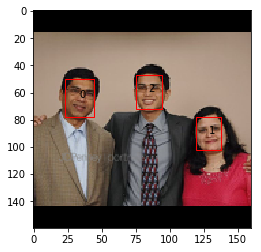

<Figure size 23040x23040 with 0 Axes>

(160, 160, 3)
0 [[ 0.07818673  0.9092023   0.01261097]] ['samir']
(160, 160, 3)
1 [[ 0.03455641  0.01503017  0.95041343]] ['sangeeta']
(160, 160, 3)
2 [[ 0.87194155  0.02222094  0.10583751]] ['atharva']


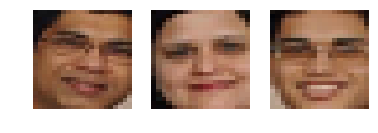

In [9]:
import matplotlib.patches as patches
from matplotlib import pyplot
image_file='/faceml/sampleimages/image1.jpg'
detector = MTCNN()
x1, y1, x2, y2, faces = extract_all_faces(detector, image_file)
show_image(image_file,x1, y1, x2, y2)
for i in range(len(faces)):
    pyplot.subplot(1, len(x1), i+1)
    pyplot.axis('off')
    pyplot.imshow(faces[i])
    print(faces[i].shape)
    embedding = get_embedding(model, faces[i])
    # prediction for the face
    samples = in_encoder.transform(embedding.reshape(1,-1))
    yhat_class = svcmodel.predict(samples)
    yhat_prob = svcmodel.predict_proba(samples)
    # get name
    class_index = yhat_class[0]
    class_probability = yhat_prob[0,class_index] * 100
    predict_names = out_encoder.inverse_transform(yhat_class)
    print(i, yhat_prob, predict_names)
